In [5]:
!pip install opendatasets timm lightning albumentations --upgrade --quiet

## Download the dataset from kaggle

In [2]:
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data'
od.download(dataset)

100%|██████████| 2.29G/2.29G [00:18<00:00, 135MB/s]


## Import the necessary libraries

In [39]:
# custom modules
%load_ext autoreload
%autoreload 2
import utilities
#import model_functions
import model_factory

#lightning modules and callbacks
import lightning_data
import lightning_model
import train_info
import learning_curves
import confusion_matrix

import os

# timm models
import timm

# torch modules (temporarily)
import torch.nn as nn
import torch
# pytorch lightning (for checkpointing callbacks)
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mount GDrive partition to store checkpoints

In [4]:
# necessary, as checkpoints will be saved on GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set-up the configuration

In [40]:
# default training configuration
config = {
    'model_name': 'efficientnet_b0', # name of the pretrained model
    'classifier_name': 'linear', # name of the classifier (e.g. linear/nonlinear)
    'classifier_type': None, # leave it None
    'layers': 'classifier', # layers to train (e.g. first (starting from last), second (starting from last), all)
    'augmentation': 'normal', # augmentation type (e.g. normal or strong)
    'classes_weight': None, # weights for each class
    'batch_size': 128,
    'val_split': 0.1,
    'n_epochs': 20,
    'optimizer': 'Adam',
    'scheduler': '', # leave it empty to not use any scheduling
    'image_size': None,
    'mean': None,
    'std': None
    }

config['classifier_type'] = model_factory.get_linear_classifer if config['classifier_name'] == 'linear' else model_factory.get_simple_non_linear_classifier


# path to save the checkpoints of this model
checkpoint_path = os.path.join('/content/drive/MyDrive/models/', config['model_name'], config['classifier_name']+ " " + config['layers'] + " " + config['augmentation'] + " " + config['optimizer'] + " " + config['scheduler'])


In [41]:
checkpoint_path

'/content/drive/MyDrive/models/efficientnet_b0/linear classifier normal Adam '

## Create the model to be trained with Pytorch Lightning

In [ ]:
# specify here the model configuration
#arch_name = 'efficientnet_b0'
#classifier_name = 'linear'
#classifier_type = model_factory.get_linear_classifer if classifier_name == 'linear' else model_factory.get_simple_non_linear_classifier
#layers_version = 'all'
#data_aug_name = " (strong aug)"
#layers_version_name = layers_version + data_aug_name
#n_epochs = 20

# create the model
#model, config = model_factory.get_model(arch_name, classifier_type, layers_version, n_epochs=n_epochs)

# set checkpoint path for this specific model configuration
# so that each model will be saved in a different folder
#checkpoint_path = os.path.join('/content/drive/MyDrive/models/', arch_name, classifier_name, layers_version_name)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

4,010,110 total parameters.
4,010,110 trainable parameters.


## Set up the Pytorch Lightning modules and callbacks

In [42]:
# dataloader
pneumonia_data = lightning_data.PneumoniaDataModule(config)
# lightning module
pneumonia_model = lightning_model.PneumoniaModel(config)

# callback to print training info
training_info_callback = train_info.PrintTrainingInfoCallback()
# callback to show learning curves after training is done
learning_curves_callback = learning_curves.PlotLearningCurvesCallback()
# callback to show confusion matrix after test is done
conf_matrix_callback = confusion_matrix.PlotConfusionMatrixCallback()
#callback to track training times
timer = pl.callbacks.Timer()
# store the metrics in a csv format
csv_logger = CSVLogger(save_dir = checkpoint_path, name="logs")

# callback to save the best model found during training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path, # checkpoints are saved to GDrive, in case runtime disconnects
    monitor="val_acc",
    mode='max',
    save_top_k=1,
    verbose=True,
    save_last = True, # save last model (to restore in case runtime disconnects)
    )

callbacks = [training_info_callback,learning_curves_callback,conf_matrix_callback,checkpoint_callback,timer]

# create the trainer
trainer = pl.Trainer(
        max_epochs=config['n_epochs'],
        log_every_n_steps=1,
        callbacks = callbacks,
        logger = csv_logger
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


4,010,110 total parameters.
2,562 trainable parameters.
CPU cores: 2, Device: cuda, GPU: Tesla T4


## Training

In [43]:
# uncomment to restore training from last saved checkpoint (in case something went wrong) and comment the other
#trainer.fit(pneumonia_model, datamodule=pneumonia_data, ckpt_path=os.path.join(checkpoint_path,'last.ckpt'))
trainer.fit(pneumonia_model, datamodule=pneumonia_data)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/drive/.shortcut-targets-by-id/1nb9AzBFDAluJm-mWDnfgbTc7rf_8PNFd/models/efficientnet_b0/linear classifier normal Adam  exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 4.0 M 
1 | criterion | NLLLoss      | 0     
-------------------------------------------
2.6 K     Trainable params
4.0 M     Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 37: 'val_acc' reached 43.58452 (best 43.58452), saving model to '/content/drive/.shortcut-targets-by-id/1nb9AzBFDAluJm-mWDnfgbTc7rf_8PNFd/models/efficientnet_b0/linear classifier normal Adam /epoch=0-step=37.ckpt' as top 1


Epoch: 001
	Train Loss: 0.3729, Train Accuracy: 86.56%
	Val Loss: 123.0169, Val Accuracy: 43.58%
	Elapsed time: 0h 4m 44s, Remaining Time: 1h 29m 48s


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


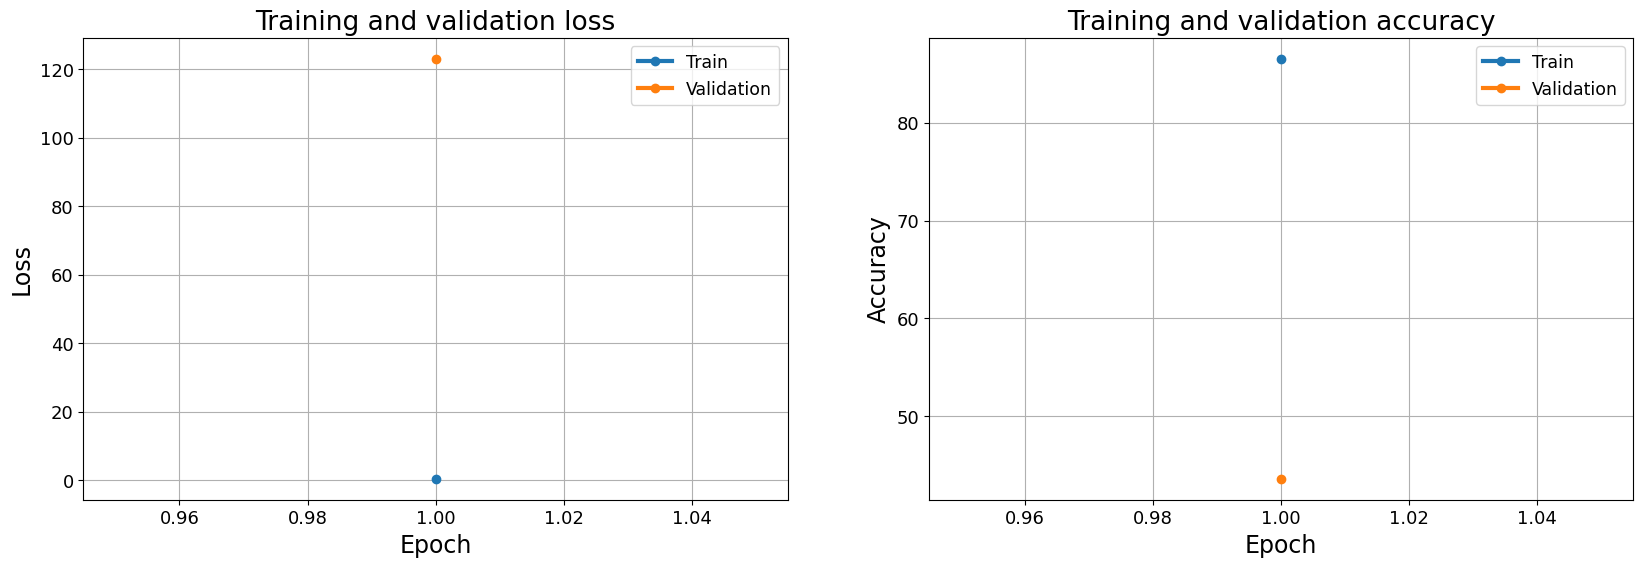

In [44]:
utilities.plot_results(checkpoint_path)

## Test

4,010,110 total parameters.
2,562 trainable parameters.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

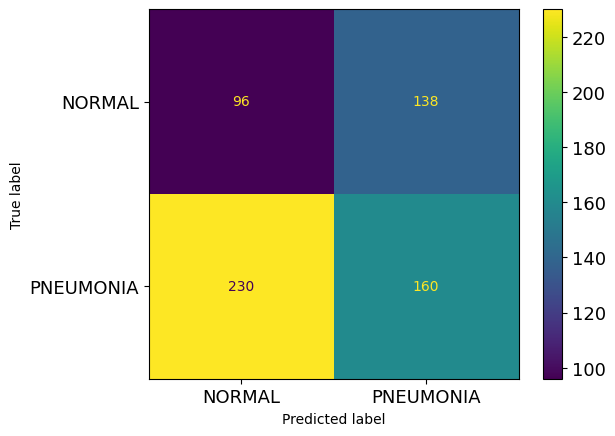

[{}]

In [45]:
# retrieve the best model from checkpoints
best_model_path = checkpoint_callback.best_model_path
#best_model_path = checkpoint_path + "/epoch=6-step=259.ckpt"
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=config)
pneumonia_model = best_model

# test the best model
trainer.test(pneumonia_model, datamodule=pneumonia_data)
#trainer.test(ckpt_path="best", datamodule=pneumonia_data) # alternatively, to test the best model directly

In [ ]:
print(f"Test accuracy: {pneumonia_model.test_acc*100:.2f}%")
print(f"Precision: {pneumonia_model.test_precision*100:.2f}%")
print(f"Recall: {pneumonia_model.test_recall*100:.2f}%")
print(f"F1-score: {pneumonia_model.test_f1*100:.2f}%")

Test accuracy: 91.25%
Precision: 88.13%
Recall: 98.97%
F1-score: 93.24%


## Retrieve training loss and accuracy

In [ ]:
# to retrieve training info
ckpt = torch.load(os.path.join(checkpoint_path,'last.ckpt'))
#ckpt['callbacks']['PlotLearningCurvesCallback']

In [ ]:
# time elapsed in seconds to 'train' and 'validate'
ckpt['callbacks']['Timer']['time_elapsed']

{'train': 2136.351640135,
 'sanity_check': 0,
 'validate': 9.658445682999627,
 'test': 0,
 'predict': 0}

## Apply Grad-CAM XAI method

In [ ]:
!pip -q install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#best_model_path = checkpoint_callback.best_model_path # if same session, this will retrieve the path for you
best_model_path = checkpoint_path + "/epoch={}-step={}.ckpt" # replace {} with epoch and step of best model
best_model = lightning_model.PneumoniaModel.load_from_checkpoint(best_model_path, h=config)
pneumonia_model = best_model

In [ ]:
# extract the model from lightning module
model_lightning = pneumonia_model.model.eval().cpu()
# get the name of the architecture (used later)
model_lightning_name = model_lightning.default_cfg['architecture']

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from PIL import Image

In [ ]:
instance_name = 'xray.jpeg' # name of the image instance we want to explain with Grad-CAM

img = np.array(Image.open(instance_name).convert('RGB'))
img = cv2.resize(img, (config['image_size'], config['image_size']))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=config['mean'], std=config['std'])

In [ ]:
# retrieve the proper feature layer to be used for explanation
if model_lightning_name == 'legacy_xception':
  target_layers = [model_lightning.conv4]
elif model_lightning_name == 'densenet121':
  target_layers = [model_lightning.features.denseblock4.denselayer16]
elif model_lightning_name == 'resnet50':
  target_layers = [model_lightning.layer4[-1]]


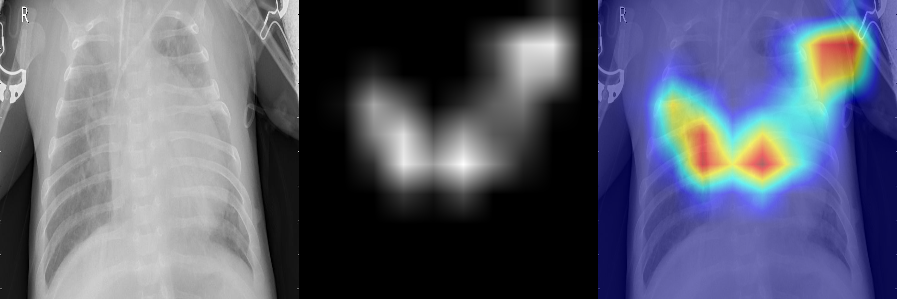

In [ ]:
with GradCAM(model=model_lightning, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor) # activation map generated for the top scoring class
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)